In [25]:
import ipywidgets as widgets
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import shap

In [2]:
cd ~/recimpute

/home/guillaume/recimpute


In [3]:
%load_ext autoreload
%autoreload 2
from Datasets.Dataset import Dataset
from Clustering.ShapeBasedClustering import ShapeBasedClustering
from recimpute import load_models_from_tr

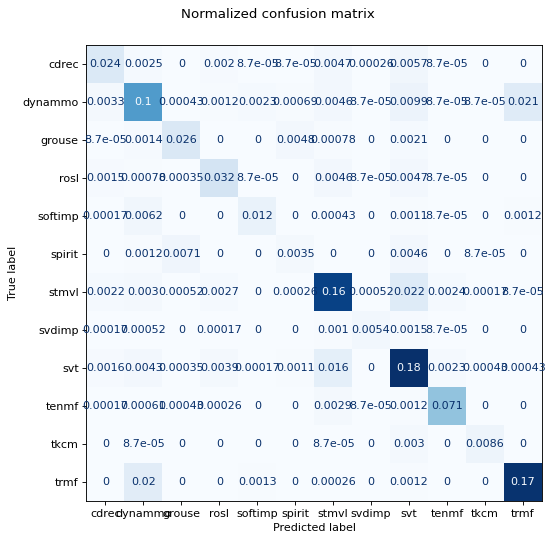

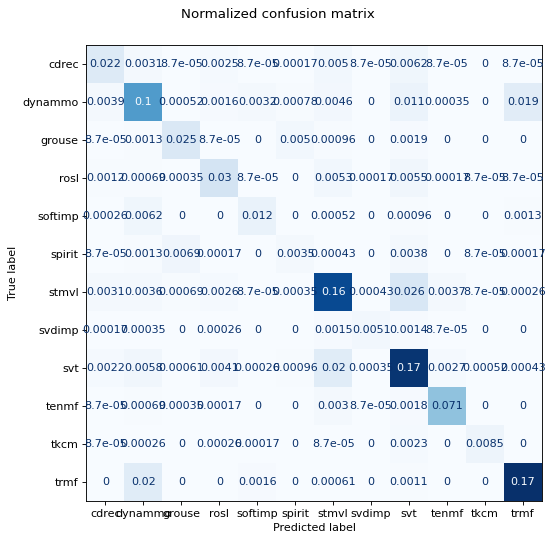

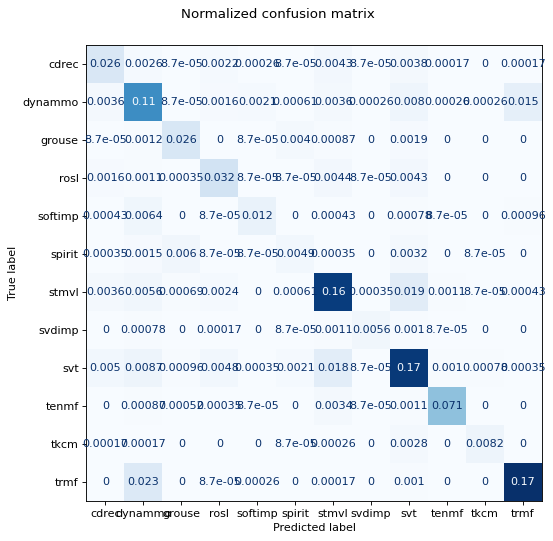

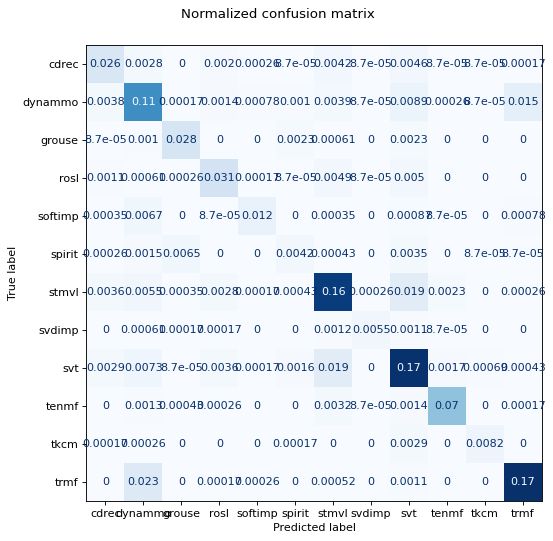

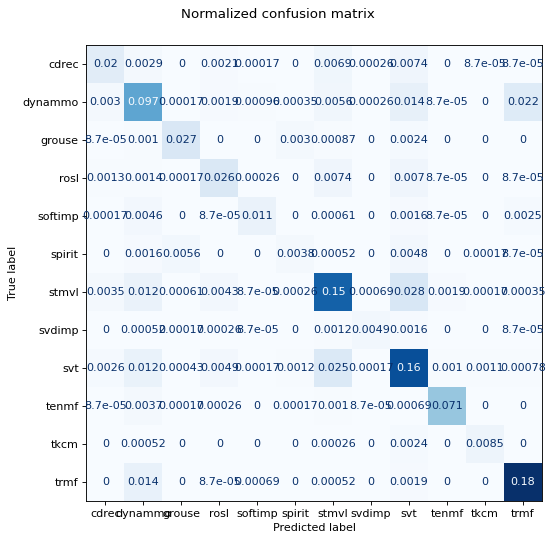

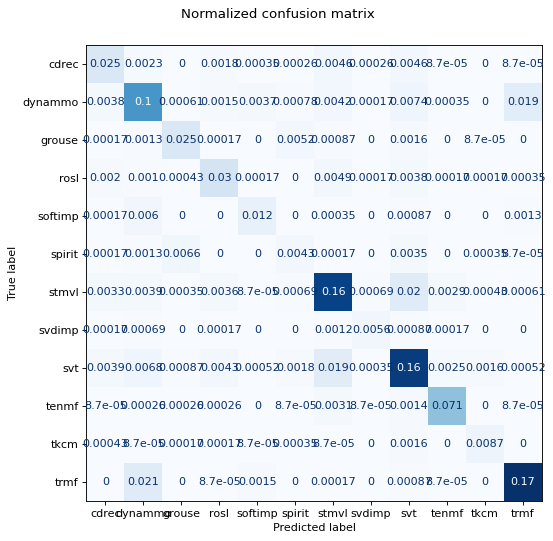

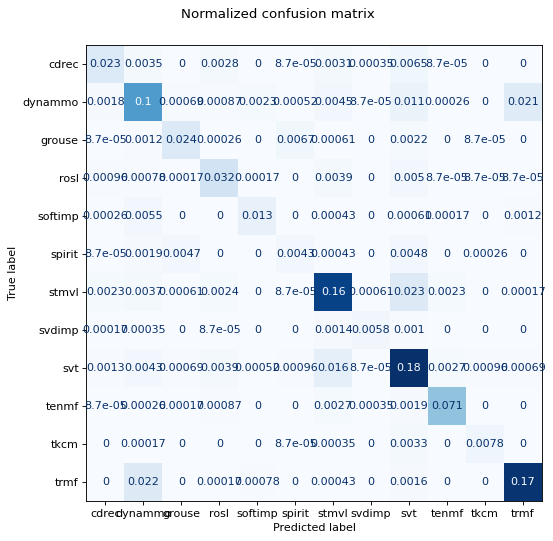

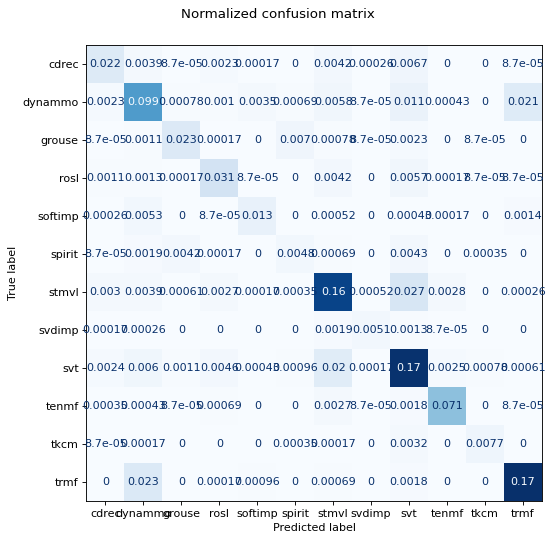

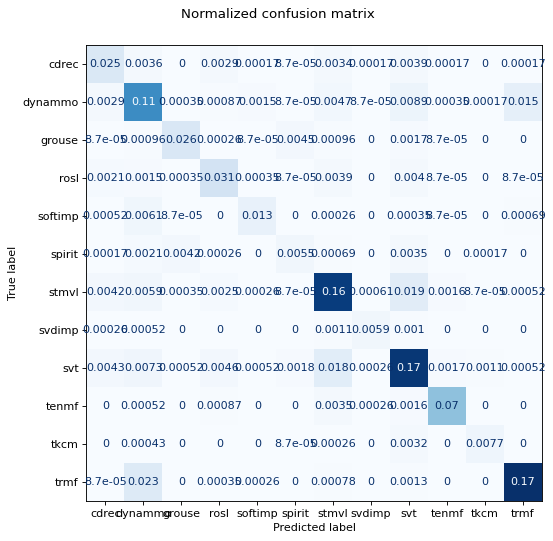

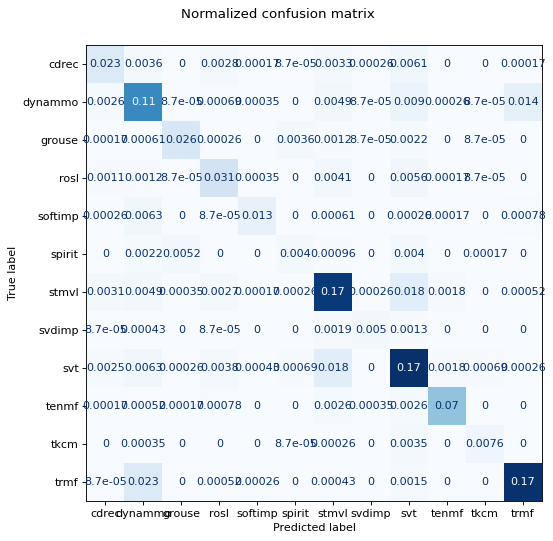

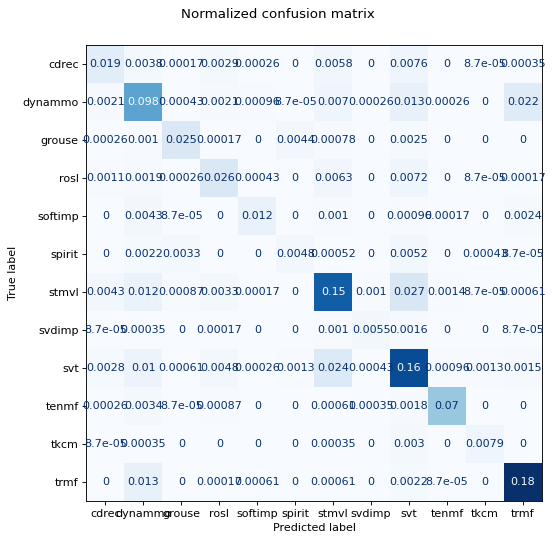

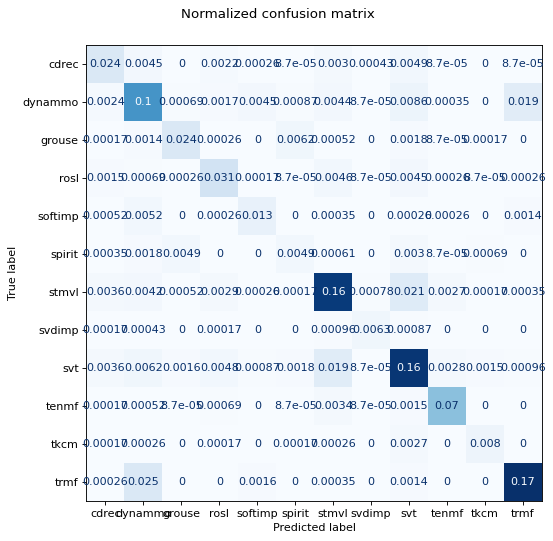

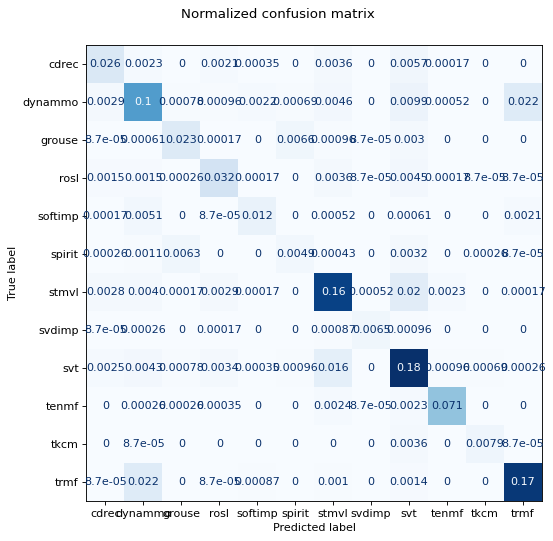

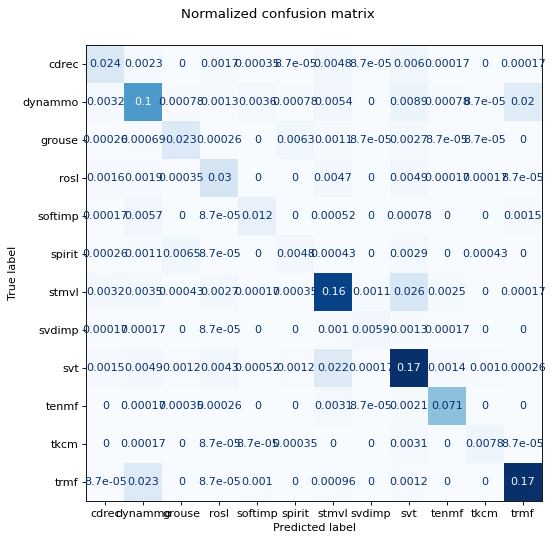

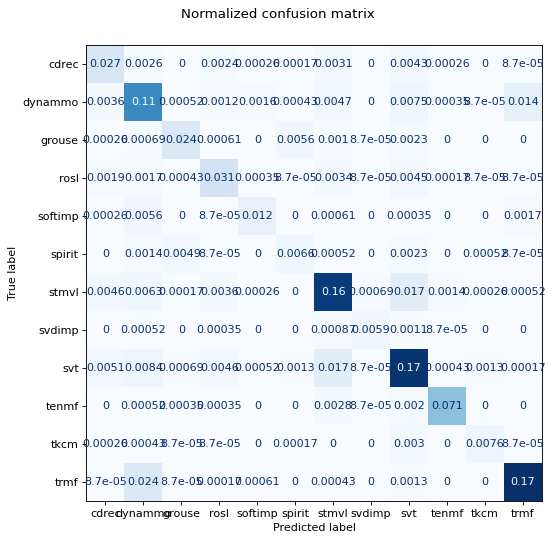

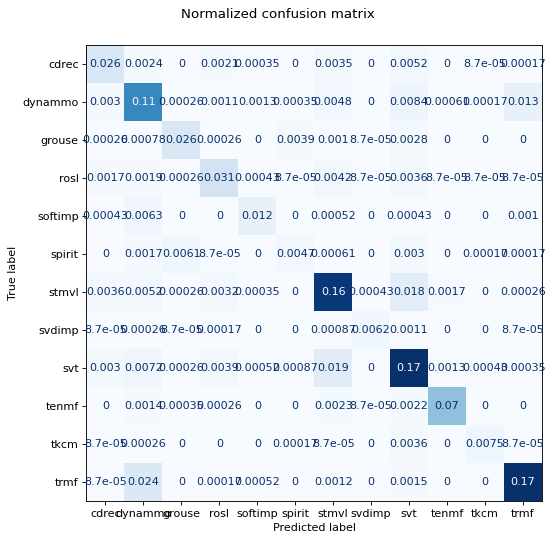

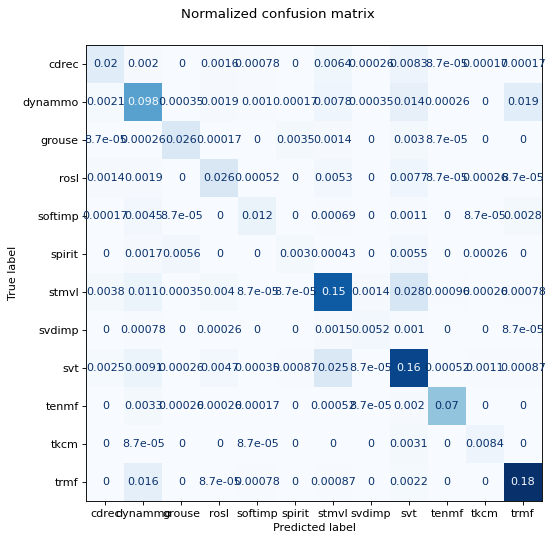

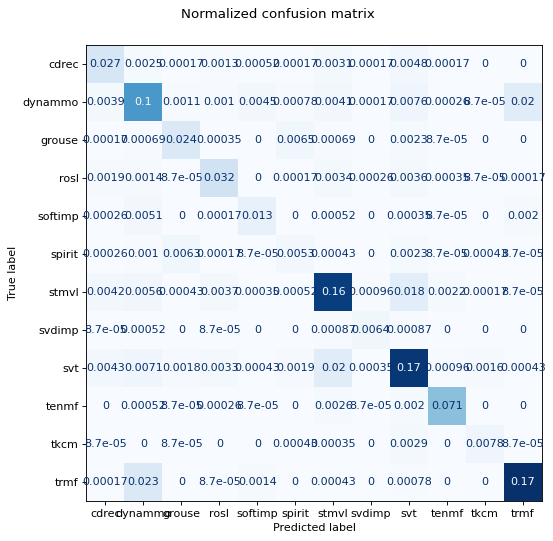

In [5]:
# IMPORTANT: the model which archive id's specified below and which should be loaded and explained, MUST HAVE BEEN 
#            TRAINED WITH ModelsTrainer.CONF['SAVE_TRAIN_SET'] = True. You can change this parameter value 
#            in the config file: Config/modelstrainer_config.yaml.

#            If your model wasn't trained with this parameter set to True, the code below will raise an exception.


id = '3004_0120_54068' # <-- CHANGE THIS /!\ this is the id of the training run that contains the model you want to explain

tr, models = load_models_from_tr(id)

In [6]:
def load_data(data_to_load):
    data = tr.load_set_from_archive(data_to_load)
    X, y = data.loc[:, ~data.columns.isin(['Label', 'Cluster ID', 'Data Set Name'])], data['Label']
    feature_names = X.columns.tolist()
    target_names = y.unique().tolist()
    X = X.to_numpy().astype('float32')
    y = y.to_numpy().astype('str')
    return X, y, feature_names, target_names

In [7]:
X_train, _, _, _ = load_data('train')
X_test, y_test, feature_names, target_names = load_data('test')
X_test.shape, y_test.shape

((24808, 432), (24808,))

In [12]:
# drop-down list to select the model to analyse/interpret
dropdown_model = widgets.Dropdown(
    options=list(zip(models, range(len(models)))),
    value=0, description='Select Model:')
dropdown_model

Dropdown(description='Select Model:', options=((-1: VotingClassifier, 0), (273: MaxAbsScaler(), PCA(), KNeighb…

In [13]:
model_to_interpret = models[dropdown_model.value]
model_predict_proba = model_to_interpret._custom_predict_proba(
    model_to_interpret.trained_pipeline_prod if model_to_interpret.trained_pipeline_prod is not None \
    else model_to_interpret.best_cv_trained_pipeline
)
model_to_interpret

-1: VotingClassifier

## LIME

In [14]:
shorter_feature_names = {f'F_{i}': s for i, s in enumerate(feature_names)}
shorter_feature_names

{'F_0': 'Values__variance_larger_than_standard_deviation_tsfresh',
 'F_1': 'Values__has_duplicate_max_tsfresh',
 'F_2': 'Values__has_duplicate_min_tsfresh',
 'F_3': 'Values__has_duplicate_tsfresh',
 'F_4': 'Values__sum_values_tsfresh',
 'F_5': 'Values__abs_energy_tsfresh',
 'F_6': 'Values__mean_abs_change_tsfresh',
 'F_7': 'Values__mean_change_tsfresh',
 'F_8': 'Values__mean_second_derivative_central_tsfresh',
 'F_9': 'Values__median_tsfresh',
 'F_10': 'Values__mean_tsfresh',
 'F_11': 'Values__length_tsfresh',
 'F_12': 'Values__standard_deviation_tsfresh',
 'F_13': 'Values__variance_tsfresh',
 'F_14': 'Values__skewness_tsfresh',
 'F_15': 'Values__kurtosis_tsfresh',
 'F_16': 'Values__root_mean_square_tsfresh',
 'F_17': 'Values__absolute_sum_of_changes_tsfresh',
 'F_18': 'Values__longest_strike_below_mean_tsfresh',
 'F_19': 'Values__longest_strike_above_mean_tsfresh',
 'F_20': 'Values__count_above_mean_tsfresh',
 'F_21': 'Values__count_below_mean_tsfresh',
 'F_22': 'Values__last_location

In [18]:
lime_explainer = LimeTabularExplainer(
    X_train, 
    feature_names=shorter_feature_names.keys(), class_names=target_names, 
    discretize_continuous=True)

In [19]:
i = np.random.randint(0, X_test.shape[0]) # explaination for 1 test sample
exp = lime_explainer.explain_instance(
    X_test[i], 
    model_predict_proba, 
    num_features=20, 
    top_labels=len(target_names))

In [21]:
#exp.save_to_file('Experiments/lime_exp.html')
exp.show_in_notebook(show_table=True, show_all=True)

## SHAP

In [26]:
shap.initjs()

In [27]:
X_train_summary = shap.kmeans(X_train, 5)
shap_explainer = shap.KernelExplainer(model_predict_proba, X_train_summary)
shap_values = shap_explainer.shap_values(X_test[:10,:])

  0%|          | 0/10 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

## Global explanation

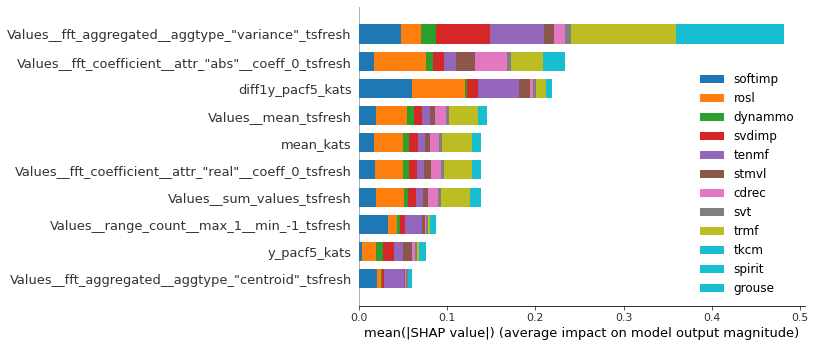

In [28]:
shap.summary_plot(
    shap_values, X_test, class_names=target_names, feature_names=feature_names,
    color=plt.get_cmap('tab10'), max_display=10
)

## Explanation per class

In [29]:
# drop-down list to select the label
dropdown_label = widgets.Dropdown(
    options=list(zip(target_names, range(len(target_names)))),
    value=0, description='Select Label:')
dropdown_label

Dropdown(description='Select Label:', options=(('dynammo', 0), ('rosl', 1), ('svt', 2), ('stmvl', 3), ('cdrec'…

In [30]:
current_label = target_names[dropdown_label.value]
current_label

'dynammo'

In [31]:
print(f'Current label Shown: {current_label}')
shap.force_plot(shap_explainer.expected_value[target_names.index(current_label)], 
                shap_values[target_names.index(current_label)], 
                X_test[:10,:], feature_names=feature_names)

Current label Shown: dynammo


Current label Shown: dynammo


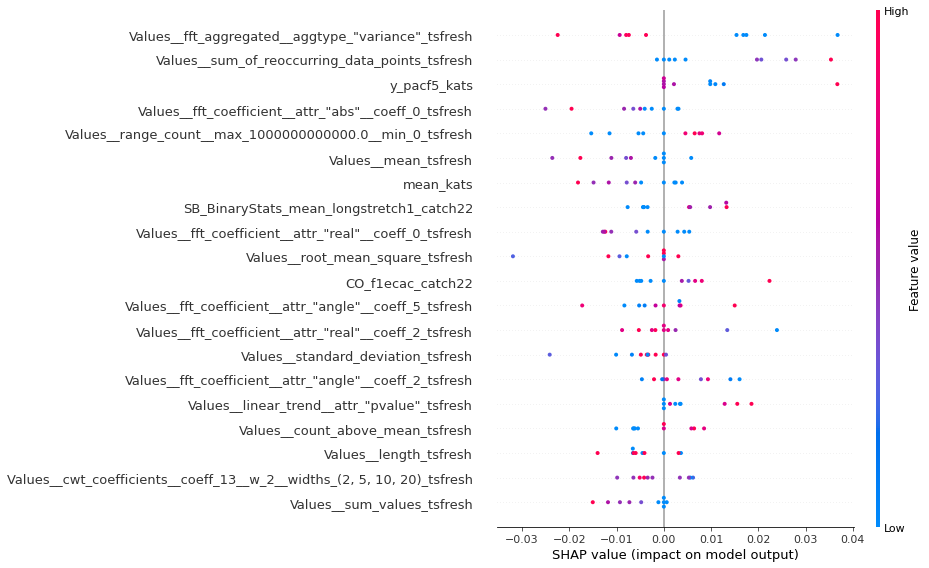

Current label Shown: rosl


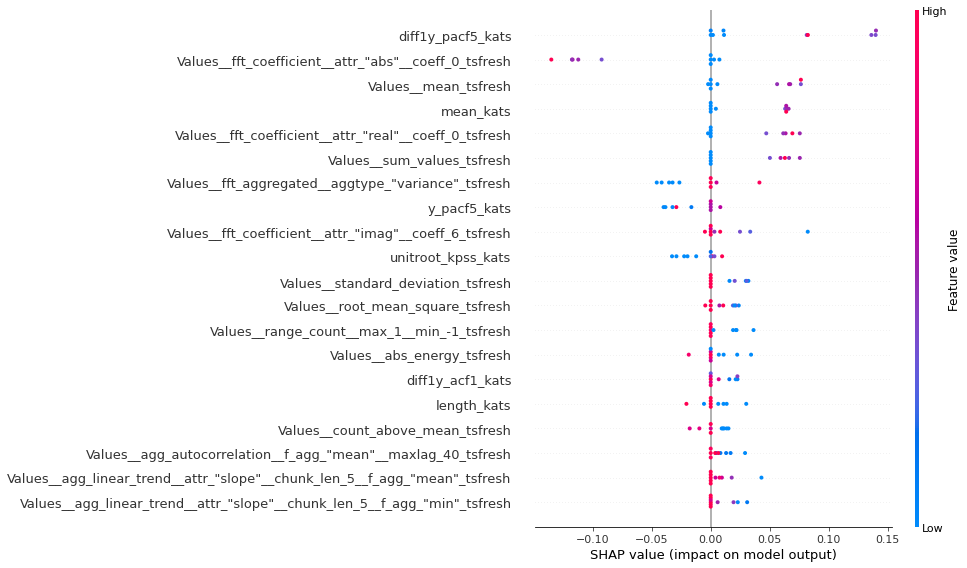

Current label Shown: svt


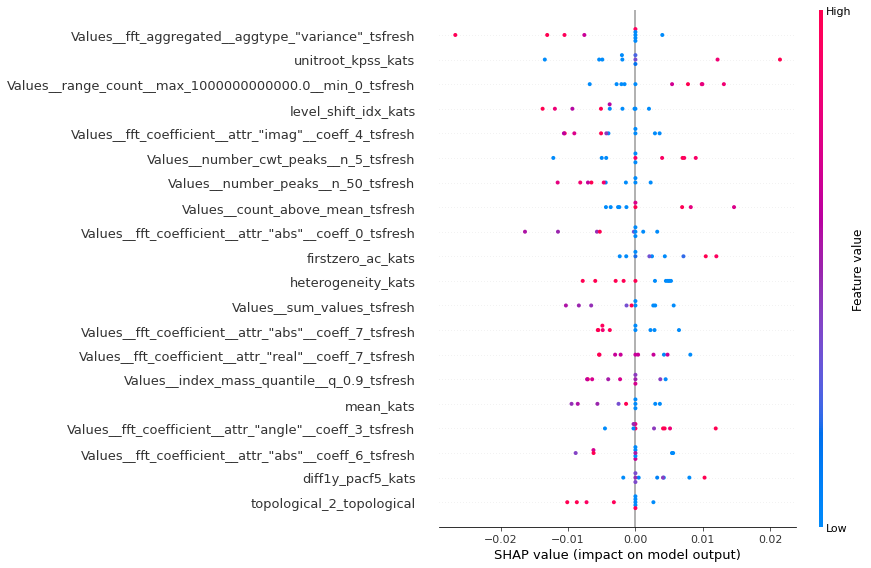

Current label Shown: stmvl


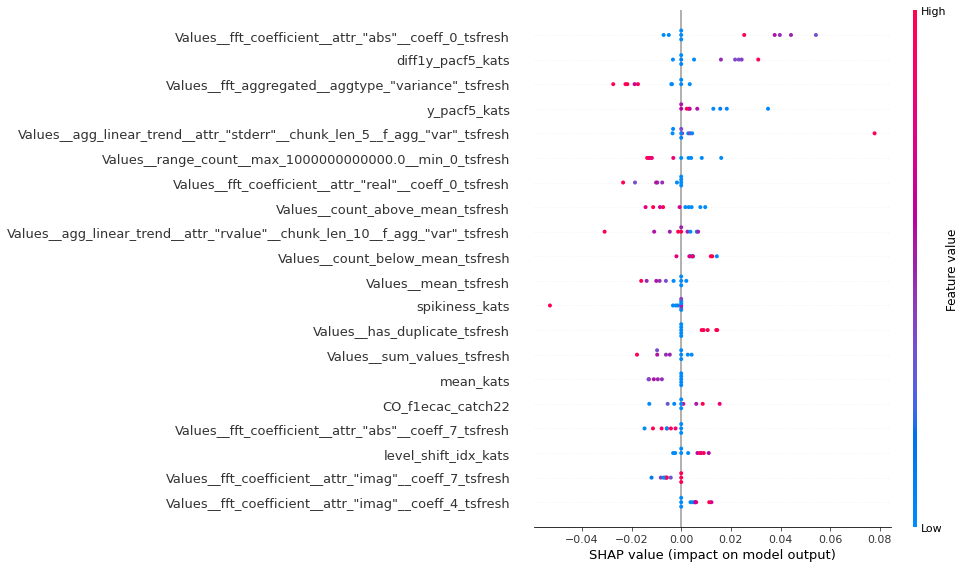

Current label Shown: cdrec


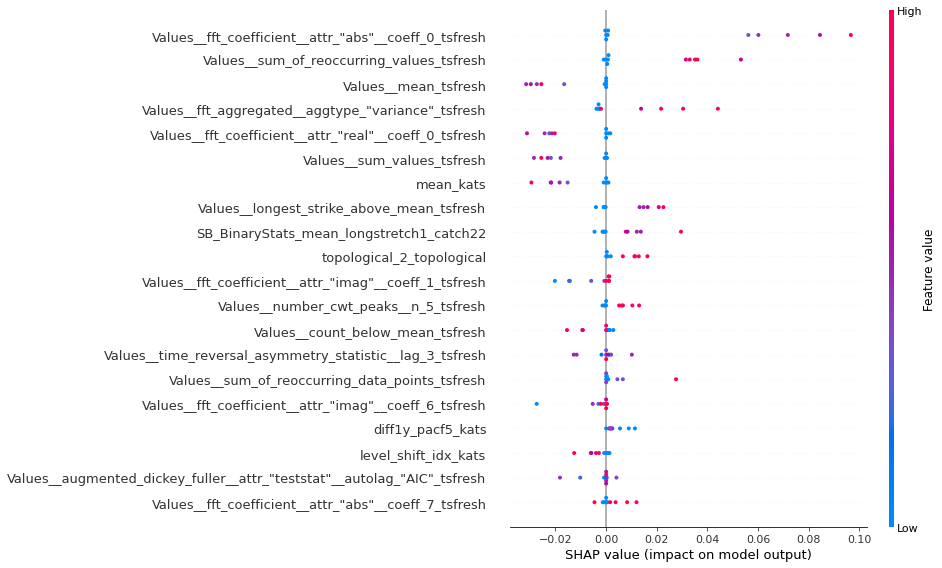

Current label Shown: trmf


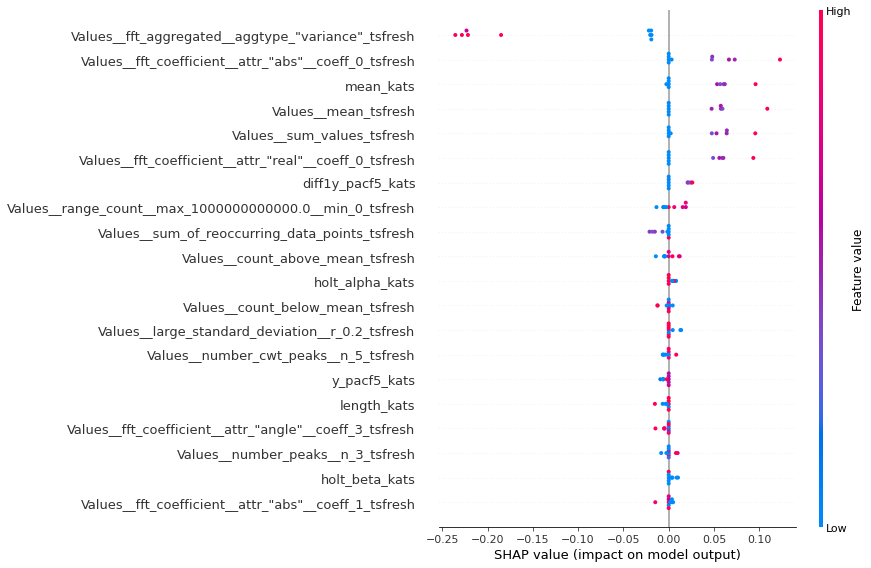

Current label Shown: tenmf


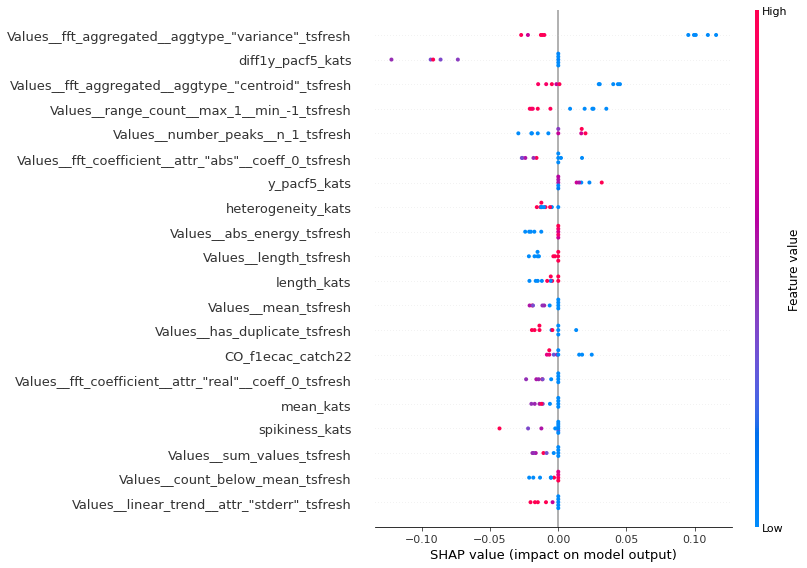

Current label Shown: grouse


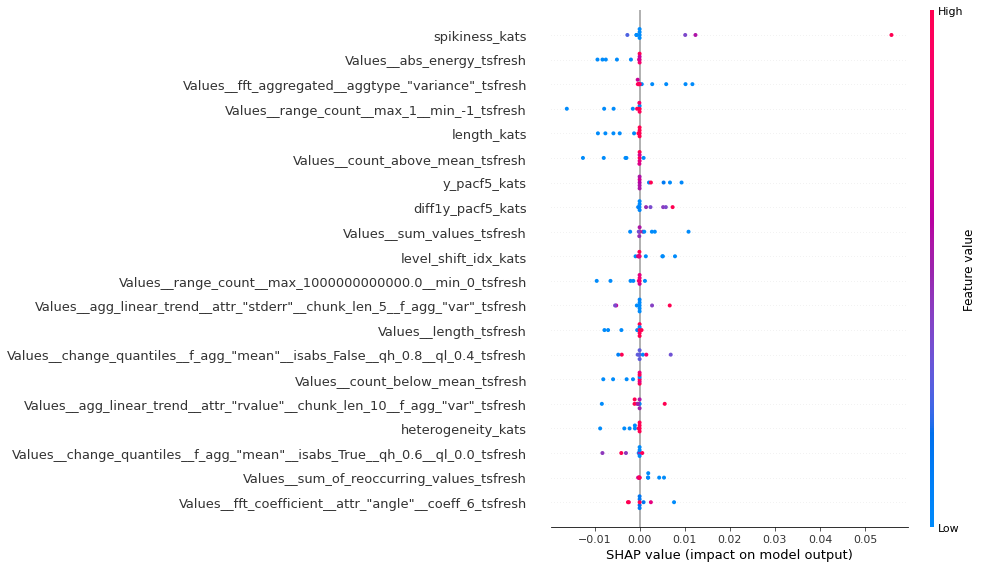

Current label Shown: softimp


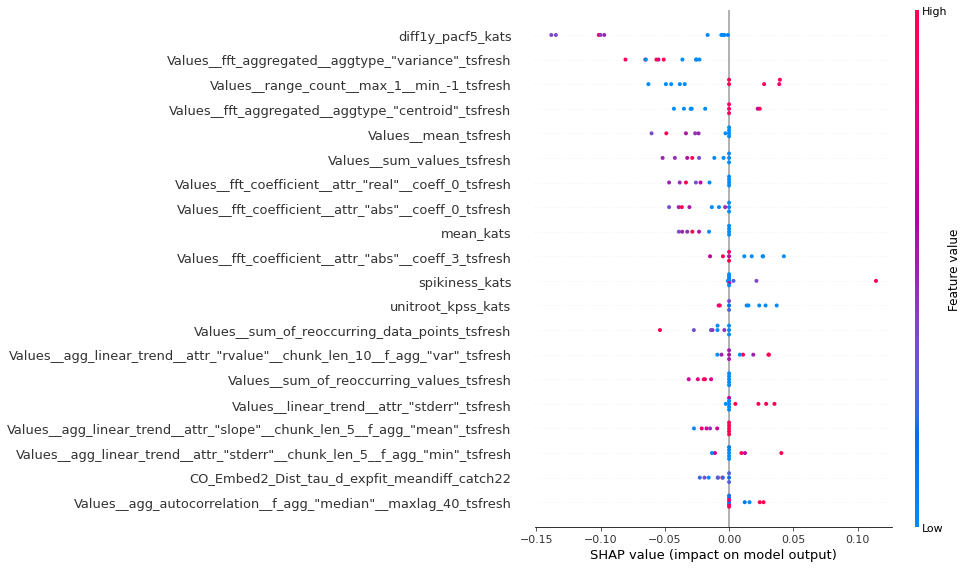

Current label Shown: spirit


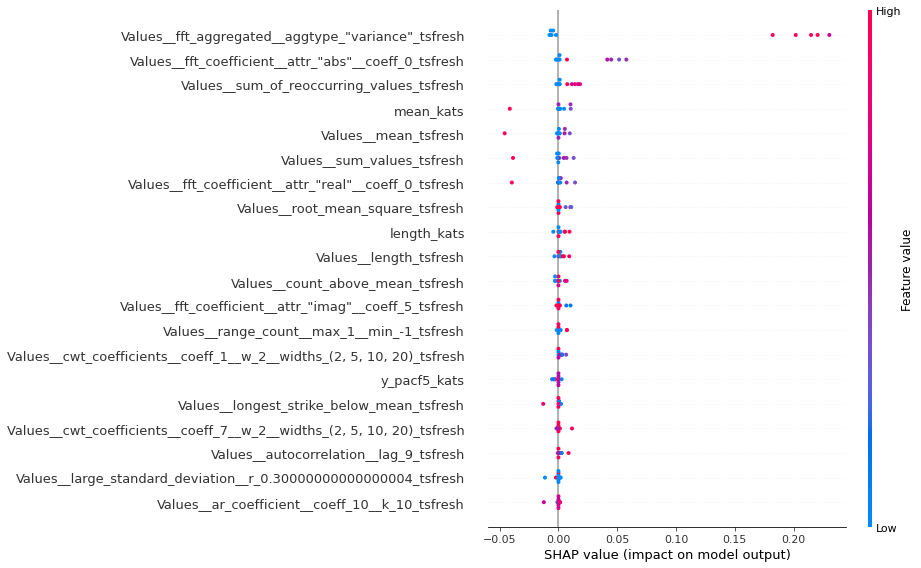

Current label Shown: tkcm


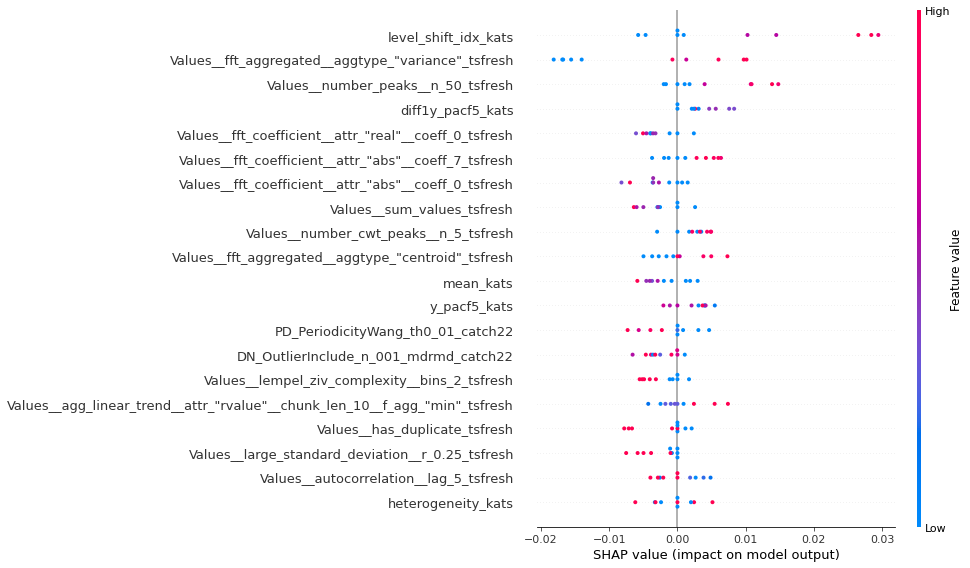

Current label Shown: svdimp


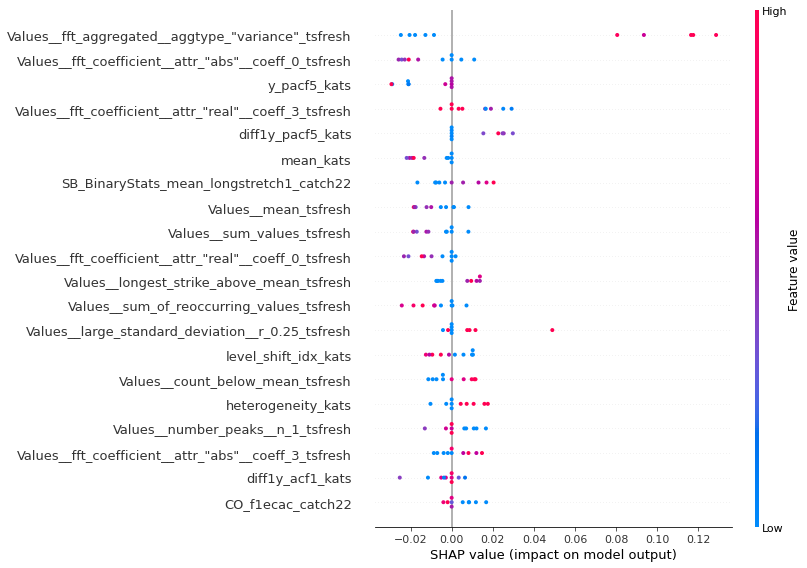

In [32]:
for lbl in target_names:
    print(f'Current label Shown: {lbl}')
    shap.summary_plot(shap_values=shap_values[target_names.index(lbl)],
                      features=X_test[:10,:], feature_names=feature_names)